In [2]:
import numpy as np
import pandas as pd
from importlib import reload
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import shared
import config
import provider_yfinance as provider
import model
import plot

reload(shared)
reload(config)
reload(provider)
reload(model)
reload(plot)

plot.Notebook()

mpl.rcParams['figure.figsize'] = (16, 9)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.unicode_minus']=False
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

cfg = config.get_config('^GDAXI')

# overwrite download_end_dt: use cached data
# config.save_config(cfg)

config> created config from file: './config.json'
config> config
        - base:
            - config_file_path: /mnt/c/notebooks/sandbox/config.json
        - datasets:
            - stocks: 30
            - benchmarks: 69
        - prepare:
            - data_start_dt: 2018-02-14
            - data_end_dt: 2020-01-07
            - cache_dir: /mnt/c/notebooks/sandbox/cache/20200107/
        - train:            
            - window_trading_days: [3, 5, 21, 35, 50]
            - lag_trading_days: [1, 2, 3, 4, 5]
            - label_max_high_weight: 3.0
            - label_max_close_weight: 1.0
            - settings: 12
        - model:
            - max_samples: 40
            - batch_size: 32
            - learning_rate: 0.01
            - lstm_hidden_size: 256
            - early_stopping_patience: 10
            - validation_monitor: val_mean_squared_error
            - max_epochs: 1000
            - base_dir: /mnt/c/notebooks/sandbox/model/20200107/            
        


In [3]:
import csv
import os

In [42]:
config.overwrite_end_dt(cfg, '2020-01-07')

eval_result = {}
verbose=0
for submodel_settings in cfg.train.settings:
    print(f'============\n {submodel_settings.id}\n ============')
    rs = {}
    mdl_data = provider.prepare_submodel_data(cfg, submodel_settings)
    tickers = mdl_data.ticker.unique().tolist()
    for ticker_name in tickers:
        print(f'eval> {submodel_settings.id} - {ticker_name} ...')
        ticker_data = mdl_data[mdl_data.ticker==ticker_name]
        mdl = model.create_model(cfg, submodel_settings, ticker_data, ticker_name, train_mode=False)
        mdl0 = model.create_model(cfg, submodel_settings, ticker_data, train_mode=False)
        num_samples = ticker_data.shape[0]    
        num_features = len(ticker_data.X.head(1).tolist()[0][0][0][0])
        input_dim = num_features    
        input_length = submodel_settings.lookback_days
        output_dim = 1
        X = np.hstack(np.asarray(ticker_data.X)).reshape(num_samples, input_length, input_dim)
        y = np.hstack(np.asarray(ticker_data.y)).reshape(num_samples, output_dim)        
        X0 = np.hstack(np.asarray(ticker_data.X)).reshape(num_samples, input_length, input_dim)
        y0 = np.hstack(np.asarray(ticker_data.y)).reshape(num_samples, output_dim)
        mdl_metrics = dict(zip(mdl.metrics_names, mdl.evaluate(X, y, verbose=verbose)))
        mdl0_metrics = dict(zip(mdl.metrics_names, mdl0.evaluate(X0, y0, verbose=verbose)))
        rs[ticker_name] = {
            'metrics': [
                mdl_metrics['loss'], mdl_metrics['mean_absolute_error'], mdl_metrics['mean_squared_error'],
                mdl0_metrics['loss'], mdl0_metrics['mean_absolute_error'], mdl0_metrics['mean_squared_error'],
            ]
        }
    eval_result[submodel_settings.id] = rs

 lookback_3-label_1
eval> lookback_3-label_1 - 1COV.DE ...
model> loaded model weights from '/mnt/c/notebooks/sandbox/model/20200107/lookback_3-label_1/1COV.DE/model_weights.hdf5'
model> loaded optimizer weights from '/mnt/c/notebooks/sandbox/model/20200107/lookback_3-label_1/1COV.DE/optimizer_weights.pkl'
model> loaded model weights from '/mnt/c/notebooks/sandbox/model/20200107/lookback_3-label_1/model_weights.hdf5'
model> loaded optimizer weights from '/mnt/c/notebooks/sandbox/model/20200107/lookback_3-label_1/optimizer_weights.pkl'
eval> lookback_3-label_1 - ADS.DE ...
model> loaded model weights from '/mnt/c/notebooks/sandbox/model/20200107/lookback_3-label_1/ADS.DE/model_weights.hdf5'
model> loaded optimizer weights from '/mnt/c/notebooks/sandbox/model/20200107/lookback_3-label_1/ADS.DE/optimizer_weights.pkl'
model> loaded model weights from '/mnt/c/notebooks/sandbox/model/20200107/lookback_3-label_1/model_weights.hdf5'
model> loaded optimizer weights from '/mnt/c/notebooks/sandbo

In [45]:
csv_output_stocks = []
rs = ['ticker_name']
for submodel_settings in cfg.train.settings:
    prefix = submodel_settings.id + '_'
    rs += [
        prefix + 'mdl_loss', prefix + 'mdl_mae', prefix + 'mdl_mse', prefix + 'mdl0_loss', prefix + 'mdl0_mae', prefix + 'mdl0_mse'
    ]
csv_output_stocks.append(rs)
for ticker_name in cfg.datasets.raw.stocks:
    rs = [ticker_name]
    for submodel_settings in cfg.train.settings:
        if ticker_name in eval_result[submodel_settings.id]:
            rs += eval_result[submodel_settings.id][ticker_name]['metrics']
        else:
            rs += [None, None, None, None, None, None]
    csv_output_stocks.append(rs)  
    
with open(os.path.join(cfg.model.base_dir, 'model_eval_pivot.tsv'), 'w', newline='\n', encoding='utf-8') as fp:
    writer = csv.writer(fp, delimiter='\t')
    for rs in csv_output_stocks:
        writer.writerow(rs)


In [46]:
csv_output = [
    ['ticker_name', 'submodel', 'mdl_loss', 'mdl_mae', 'mdl_mse', 'mdl0_loss', 'mdl0_mae', 'mdl0_mse']
]
for ticker_name in cfg.datasets.raw.stocks:    
    for submodel_settings in cfg.train.settings:
        rs = [ticker_name, submodel_settings.id]
        if ticker_name in eval_result[submodel_settings.id]:
            rs += eval_result[submodel_settings.id][ticker_name]['metrics']
        else:
            rs += [None, None, None, None, None, None]
        csv_output.append(rs)
    
with open(os.path.join(cfg.model.base_dir, 'model_eval.tsv'), 'w', newline='\n', encoding='utf-8') as fp:
    writer = csv.writer(fp, delimiter='\t')
    for rs in csv_output:
        writer.writerow(rs)


,ticker_name,submodel,mdl_loss,mdl_mae,mdl_mse,mdl0_loss,mdl0_mae,mdl0_mse
0,1COV.DE,lookback_3-label_1,0.410302,0.240282,0.410302,0.729286,0.624518,0.729286
1,1COV.DE,lookback_3-label_2,0.745542,0.337269,0.745542,1.907536,1.008809,1.907536
2,1COV.DE,lookback_5-label_1,0.983396,0.686268,0.983396,0.735293,0.612254,0.735293
3,1COV.DE,lookback_5-label_3,1.083075,0.744549,1.083075,1.664897,0.901473,1.664897
4,1COV.DE,lookback_7-label_1,1.005689,0.707759,1.005689,0.806237,0.694289,0.806237
...,...,...,...,...,...,...,...,...
355,WDI.DE,lookback_14-label_3,0.212662,0.327589,0.212662,15.160512,2.868350,15.160511
356,WDI.DE,lookback_21-label_5,0.347486,0.359072,0.347486,39.065971,4.361565,39.065970
357,WDI.DE,lookback_36-label_7,1.839579,0.680653,1.839579,52.647175,5.136742,52.647175
358,WDI.DE,lookback_64-label_7,0.907570,0.631364,0.907570,40.190648,4.514638,40.190647


In [42]:
# rank models by performance
df_eval = pd.read_csv(os.path.join(cfg.model.base_dir, 'model_eval.tsv'), sep='\t', low_memory=False)
# ticker model scores
scores = [10,8,5,3,2,1]
s_scores = None
for ticker_name in cfg.datasets.raw.stocks:        
    idx = df_eval[df_eval.ticker_name==ticker_name].sort_values(by='mdl_mae').index    
    scores = scores + [0] * (len(cfg.train.settings) - len(scores))
    if s_scores is None:
        s_scores = pd.Series(scores, index=idx)
    else:
        s_scores = pd.concat([s_scores, pd.Series(scores, index=idx)])
df_eval['scores'] = s_scores
# overall model scores
scores0 = np.array(scores) / 2
s_scores0 = None
for ticker_name in cfg.datasets.raw.stocks:        
    idx = df_eval[df_eval.ticker_name==ticker_name].sort_values(by='mdl0_mae').index    
    scores = scores + [0] * (len(cfg.train.settings) - len(scores))
    if s_scores0 is None:
        s_scores0 = pd.Series(scores, index=idx)
    else:
        s_scores0 = pd.concat([s_scores0, pd.Series(scores, index=idx)])
df_eval['scores0'] = s_scores0
df_eval['scores_sum'] = df_eval.scores + df_eval.scores0
df_eval.groupby(['submodel']).agg(sum).sort_values('scores_sum', ascending=False)

,mdl_loss,mdl_mae,mdl_mse,mdl0_loss,mdl0_mae,mdl0_mse,scores,scores0,scores_sum
submodel,,,,,,,,,
lookback_36-label_7,3.594238,5.565217,3.594237,61.725941,16.110832,61.725940,201,272,473
lookback_3-label_1,7.612004,5.634581,7.612004,25.740590,18.464833,25.740590,167,129,296
lookback_14-label_3,4.407269,6.925066,4.407269,38.128582,20.799287,38.128582,123,101,224
lookback_100-label_7,7.437078,8.136511,7.437078,75.374424,24.496257,75.374425,90,70,160
lookback_3-label_2,7.703750,6.790063,7.703750,46.759830,25.766495,46.759830,121,13,134
lookback_5-label_1,22.022230,15.828668,22.022230,25.155283,18.435306,25.155283,9,122,131
lookback_21-label_5,3.935031,6.867143,3.935031,70.845541,25.976133,70.845540,98,20,118
lookback_7-label_1,24.772892,17.559186,24.772892,26.633692,18.855538,26.633693,5,96,101
lookback_64-label_7,5.859085,8.507535,5.859085,68.648306,24.842781,68.648305,52,42,94


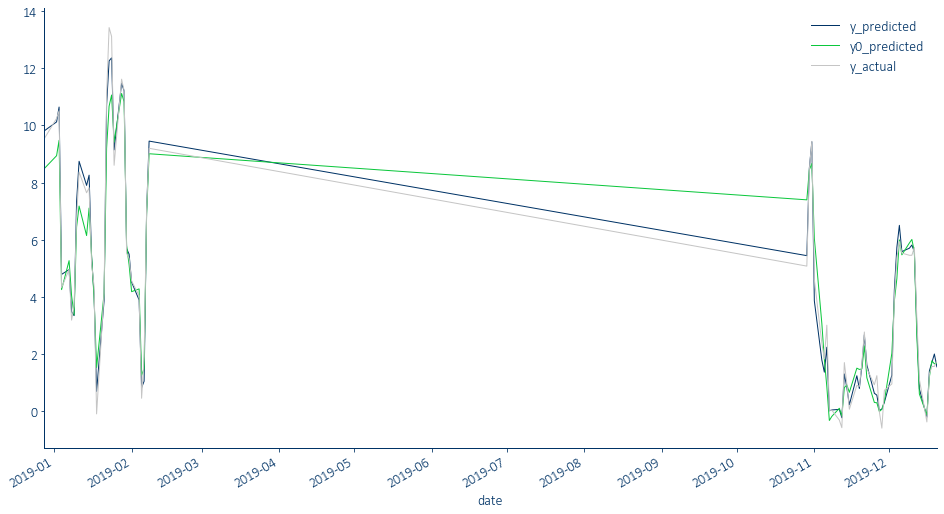

In [9]:
df_test = pd.DataFrame({
    'y_predicted': pd.Series(mdl.predict(X).flatten()),
    'y0_predicted': pd.Series(mdl0.predict(X0).flatten()),
    'y_actual': ticker_data.y
})
df_test.index = ticker_data.date
df_test.plot()

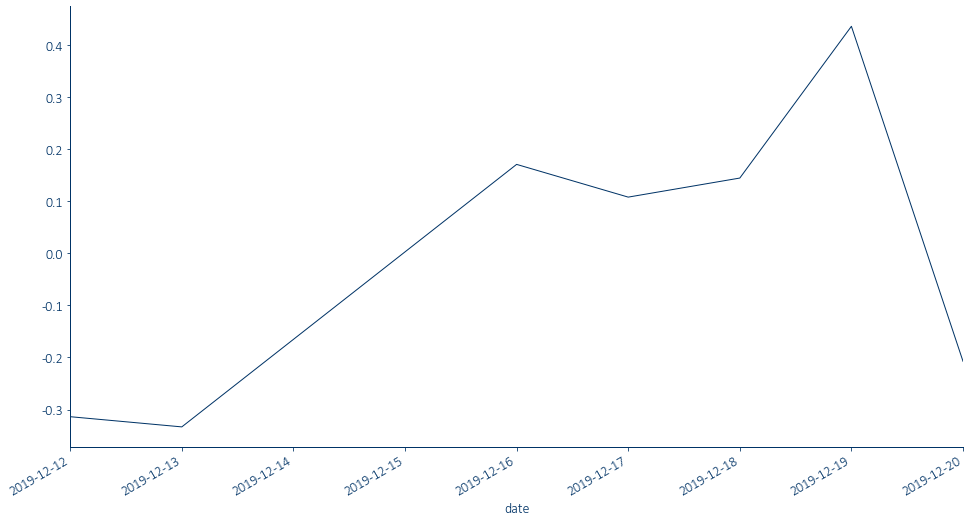

In [13]:
(df_test.y_predicted - df_test.y_actual).tail(cfg.model.max_samples-10).plot()

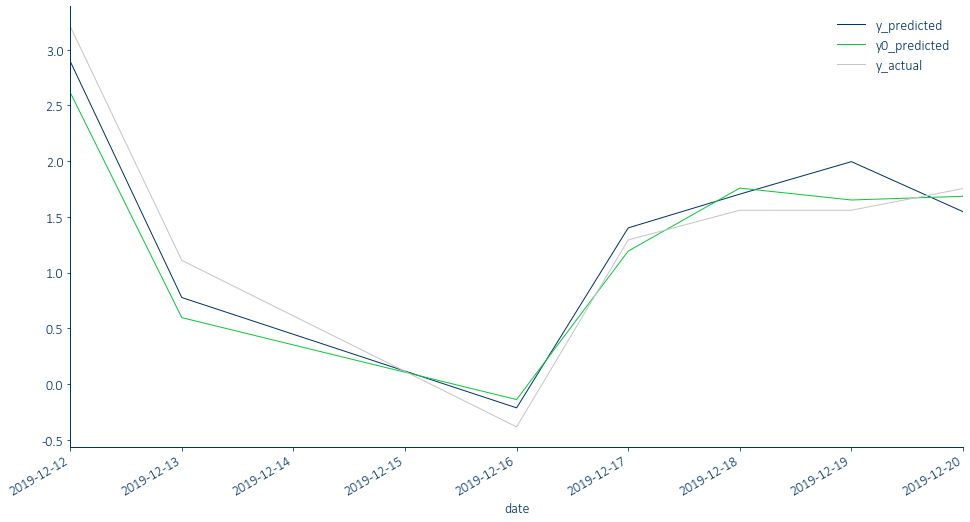

In [10]:
df_test.tail(cfg.model.max_samples-10).plot()

In [5]:
1 ticker
-> 12 submodel_settings
-> 24 models (ticker + overall)
-> weights per model
x1*m1t + 



SyntaxError: invalid syntax (<ipython-input-5-70fcb7edca27>, line 1)